In [1]:
!pip install pybaseball pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 60.9 MB/s eta 0:00:00


In [2]:
from pybaseball import statcast
import pandas as pd

# Download Statcast data for 2023 regular season (March 30 to Oct 1)
data = statcast(start_dt="2023-03-30", end_dt="2023-10-01")

print(f"✅ Download complete! Number of pitches: {len(data)}")
data.head()

This is a large query, it may take a moment to complete


/usr/local/lib/python3.12/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/186 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_co

✅ Download complete! Number of pitches: 717945


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
2440,CH,2023-10-01,89.0,-2.8,5.59,"Robertson, Nick",677008,687798,field_out,hit_into_play,...,<NA>,2.55,1.53,-1.53,31.7,1.676715,-1.896554,41.830979,30.714944,26.41202
2491,FF,2023-10-01,96.9,-2.4,5.9,"Robertson, Nick",677008,687798,NaN,foul,...,<NA>,1.09,0.76,-0.76,47.4,8.715532,3.692542,40.551342,33.656454,26.020583
2584,CH,2023-10-01,90.0,-2.93,5.56,"Robertson, Nick",677008,687798,NaN,ball,...,<NA>,2.47,1.65,-1.65,30.3,<NA>,<NA>,<NA>,<NA>,<NA>
2684,ST,2023-10-01,82.2,-3.09,5.55,"Robertson, Nick",677008,687798,NaN,ball,...,<NA>,3.14,-1.43,1.43,28.9,<NA>,<NA>,<NA>,<NA>,<NA>
2797,CH,2023-10-01,89.2,-2.87,5.58,"Robertson, Nick",677008,687798,NaN,swinging_strike,...,<NA>,2.57,1.49,-1.49,34.3,20.169759,-7.584644,37.675911,44.236969,36.187039


In [3]:
data.to_csv("statcast_2023.csv", index=False)
print("Saved as statcast_2023.csv")

✅ Saved as statcast_2023.csv


In [4]:
# Basic info
print("Number of rows:", len(data))
print("Number of columns:", len(data.columns))
print("\nColumn names:\n", data.columns.tolist()[:20])

Number of rows: 717945
Number of columns: 118

Column names:
 ['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team']


In [5]:
# Check missing values for the most important features
key_columns = ['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z',
               'pitcher', 'batter', 'balls', 'strikes', 'outs_when_up', 'inning']
print(data[key_columns].isna().sum())

pitch_type       272
release_speed    274
release_pos_x    273
release_pos_z    273
pitcher            0
batter             0
balls              0
strikes            0
outs_when_up       0
inning             0
dtype: int64


In [6]:
# How many of each pitch type
print(data['pitch_type'].value_counts())

pitch_type
FF    230309
SL    115548
SI    111147
CH     77876
FC     56798
CU     47488
ST     41864
FS     16059
KC     14862
SV      2890
FA      1114
FO       778
EP       558
KN       192
SC        74
CS        70
PO        46
Name: count, dtype: int64


In [7]:
# Columns we will use for the first model
model_cols = [
    'pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z',
    'pitcher', 'batter', 'balls', 'strikes', 'outs_when_up', 'inning',
    'stand', 'p_throws'  # pitcher/batter handedness
]

# Keep only these columns and drop rows with missing pitch_type or release_speed
df_model = data[model_cols].dropna(subset=['pitch_type', 'release_speed']).copy()

print("Rows after dropping missing values:", len(df_model))
print("Columns used:", df_model.columns.tolist())
df_model.head()

Rows after dropping missing values: 717671
Columns used: ['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'pitcher', 'batter', 'balls', 'strikes', 'outs_when_up', 'inning', 'stand', 'p_throws']


,pitch_type,release_speed,release_pos_x,release_pos_z,pitcher,batter,balls,strikes,outs_when_up,inning,stand,p_throws
2440,CH,89.0,-2.8,5.59,687798,677008,2,2,2,9,L,R
2491,FF,96.9,-2.4,5.9,687798,677008,2,2,2,9,L,R
2584,CH,90.0,-2.93,5.56,687798,677008,1,2,2,9,L,R
2684,ST,82.2,-3.09,5.55,687798,677008,0,2,2,9,L,R
2797,CH,89.2,-2.87,5.58,687798,677008,0,1,2,9,L,R


**Preliminary Visualizations**

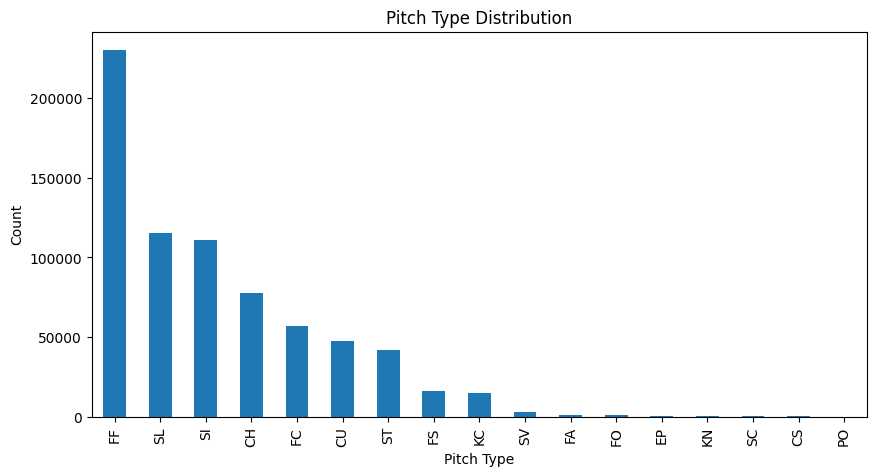

In [8]:
import matplotlib.pyplot as plt

# Count of each pitch type
pitch_counts = df_model['pitch_type'].value_counts()
pitch_counts.plot(kind='bar', figsize=(10,5), title="Pitch Type Distribution")
plt.xlabel("Pitch Type")
plt.ylabel("Count")
plt.show()

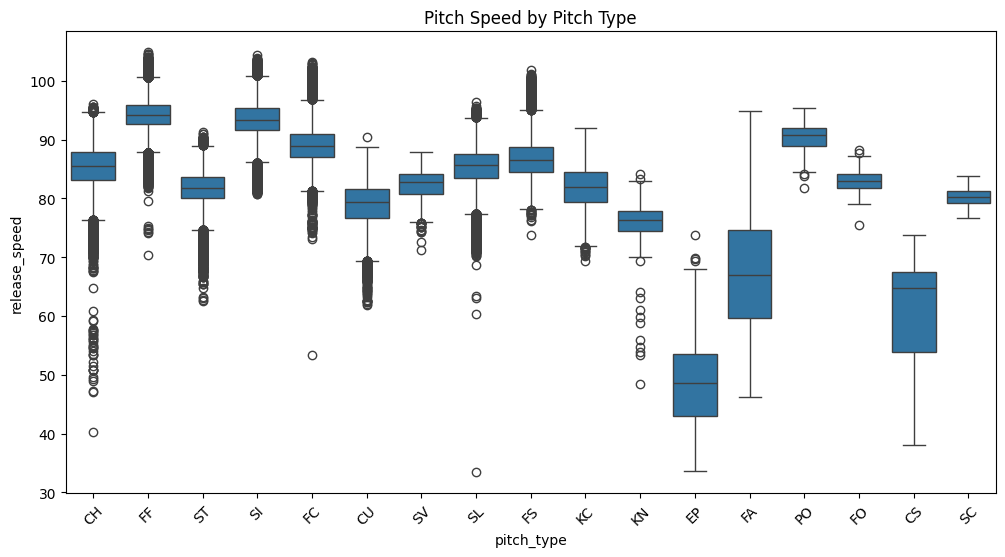

In [9]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(x='pitch_type', y='release_speed', data=df_model)
plt.title("Pitch Speed by Pitch Type")
plt.xticks(rotation=45)
plt.show()

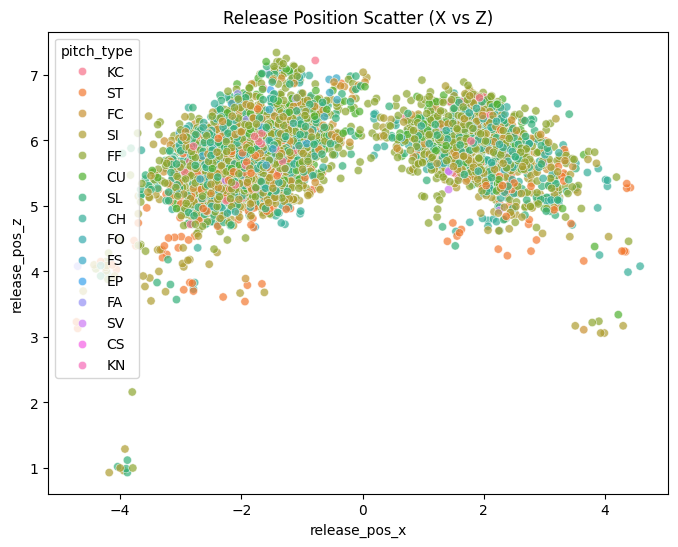

In [10]:
# Take a random sample of 5000 pitches for plotting
sample = df_model.sample(5000, random_state=42)
plt.figure(figsize=(8,6))
sns.scatterplot(x='release_pos_x', y='release_pos_z', hue='pitch_type', data=sample, alpha=0.7)
plt.title("Release Position Scatter (X vs Z)")
plt.show()

In [11]:
from sklearn.metrics import accuracy_score

# Baseline: always predict the most common pitch
most_common_pitch = df_model['pitch_type'].mode()[0]
baseline_preds = [most_common_pitch] * len(df_model)

accuracy = accuracy_score(df_model['pitch_type'], baseline_preds)
print(f"Most common pitch type: {most_common_pitch}")
print(f"Baseline accuracy: {accuracy:.4f}")

Most common pitch type: FF
Baseline accuracy: 0.3209
